## Retinal vessel detection

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from skimage.filters import frangi
from skimage.morphology import remove_small_objects
from skimage.util import img_as_bool
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.metrics import sensitivity_score, specificity_score
import seaborn as sns

In [ ]:
def load_image(file_name):
    base_name = os.path.splitext(file_name)[0]
    img_path = os.path.join("./HRF/healthy", base_name + ".jpg")
    img = cv2.imread(img_path)
    manual_path = os.path.join("./HRF/healthy_manualsegm", base_name + ".tif")
    manual = cv2.imread(manual_path, 0)
    fov_path = os.path.join("./HRF/healthy_fovmask", base_name + "_mask.tif")
    fov = cv2.imread(fov_path, 0)
    
    with output:
        clear_output(wait=True)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

    return img, manual // 255, fov // 255


def on_image_change(change):
    global img, manual, fov
    selected_image = change['new']
    img, manual, fov = load_image(selected_image)


output = widgets.Output()

global selected_image, img, manual, fov
selected_image = "01_h.jpg"  # default
img, manual, fov = load_image(selected_image)

images_list = sorted([f for f in os.listdir("./HRF/healthy") if f.endswith(".jpg")])
dropdown = widgets.Dropdown(
    options=images_list,
    value="01_h.jpg",
    description="Image: ="
)
dropdown.observe(on_image_change, names='value')
display(dropdown)
display(output)


Dropdown(description='Image: =', options=('01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', '05_h.jpg', '06_h.jp…

Output()

### 1. Image processing

In [39]:
def preprocessing(image):
    green_image = image[:,:,1]
    denoised_image = cv2.medianBlur(green_image, 5)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eqaualized_image = clahe.apply(denoised_image)

    return eqaualized_image

In [ ]:
def image_processing(image, fov_mask):
    preprocessed_image = preprocessing(image)

    frangi_image = frangi(preprocessed_image)
    
    fov_bin = (fov_mask > 0).astype(np.uint8)
    frangi_image = frangi_image * fov_bin

    normalized_frangi_image = cv2.normalize(frangi_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    binary_vessels = normalized_frangi_image.copy()
    binary_vessels[binary_vessels > 0] = 255  # binary mask

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened_img = cv2.morphologyEx(binary_vessels, cv2.MORPH_OPEN, kernel, iterations=2)
    
    dilated_img = cv2.dilate(opened_img, kernel, iterations=3)

    bool_dilated = img_as_bool(dilated_img)
    cleaned_dilated = remove_small_objects(bool_dilated, min_size=1000)
    final_img = (cleaned_dilated * 255).astype(np.uint8)

    return final_img


In [41]:
def show_results(image, vessels_mask, manual):
    bgr_image = image.copy()
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    rgb_image[vessels_mask > 0] = [0, 0, 255]
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Ground truth (manual mask)")
    plt.imshow(manual, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Detected vessels")
    plt.imshow(vessels_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Vessel detection visualization")
    plt.imshow(rgb_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [49]:
def evaluate_detection(manual_mask, detected_mask, fov):
    mask = fov > 0
    y_true = manual_mask[mask].flatten()
    y_pred = (detected_mask[mask] > 0).astype(np.uint8).flatten()

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    arithmetic_mean = (sensitivity + specificity) / 2
    geometric_mean = np.sqrt(sensitivity * specificity)

    print(f"accuracy: {accuracy:.4f}, sensitivity: {sensitivity:.4f}, specificity: {specificity:.4f}, arithmetic mean: {arithmetic_mean:.4f}, geometric mean: {geometric_mean:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

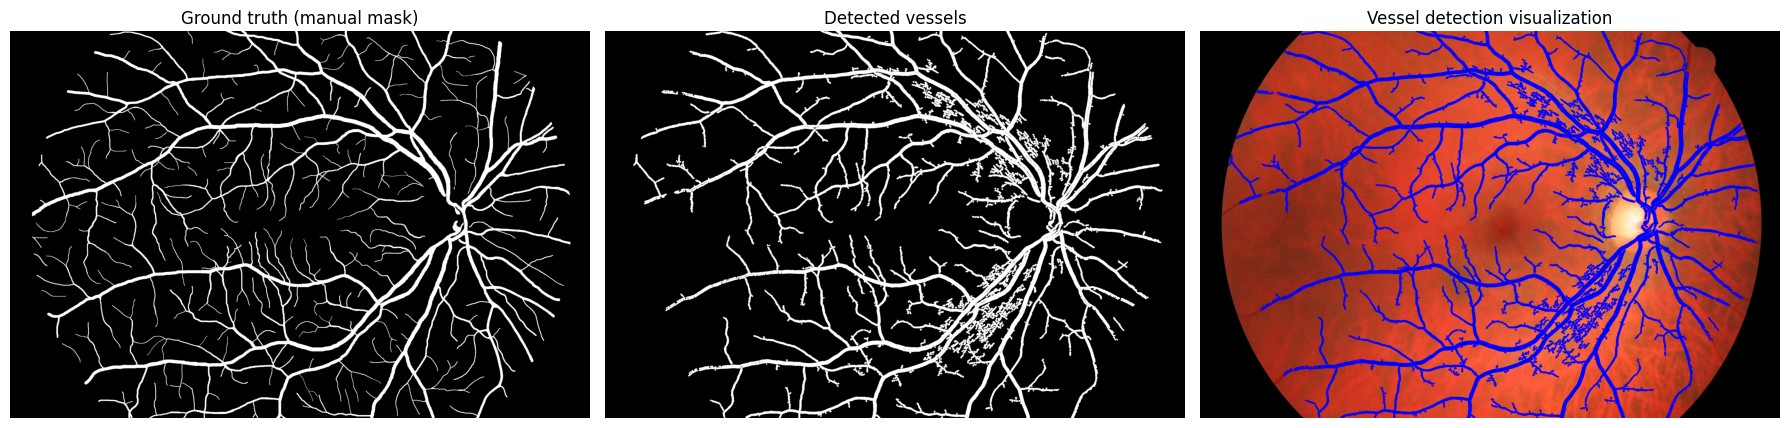

accuracy: 0.9202, sensitivity: 0.8124, specificity: 0.9350, arithmetic mean: 0.8737, geometric mean: 0.8715


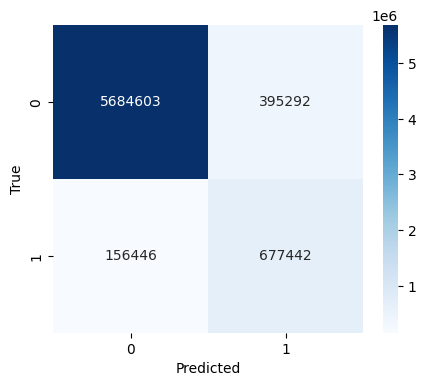

In [57]:
vessels = image_processing(img, fov)
show_results(img, vessels, manual)
evaluate_detection(manual, vessels, fov)

### 2. Machine learning classifier

### 3. Deep learning model